In [12]:
import torch
import torch.nn as nn

class HamiltonianNet(nn.Module):
    """ ハミルトニアン H(z, t) を学習するネットワーク """
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # z (dim=input_dim) と t (dim=1) を入力に取る
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1) # 出力はスカラーH
        )

    def forward(self, t, z):
        # t を z のバッチサイズに合わせて拡張
        t_vec = torch.ones(z.shape[0], 1).to(z) * t
        # z と t を結合してネットワークに入力
        tz = torch.cat([z, t_vec], dim=1)
        return self.net(tz)
    
class HamiltonianFlow(nn.Module):
    """ Hからハミルトニアンの流れ v = (dH/dp, -dH/dq) を計算する """
    def __init__(self, hamiltonian_net):
        super().__init__()
        self.h_net = hamiltonian_net

    def forward(self, t, z):
        # z を (q, p) に分割 (ここでは 2D なので z = (z0, z1) = (q, p))
        z.requires_grad_(True)
        
        # 1. H(z, t) を計算
        h = self.h_net(t, z)

        # 2. H の z に対する勾配 ∇z H を自動微分で計算
        # create_graph=True はODEソルバー内で高階微分を可能にするために必要
        grad_h = torch.autograd.grad(
            h.sum(), z, create_graph=True
        )[0]
        
        # 3. v = (dH/dp, -dH/dq) を計算
        # z = (q, p) とした場合:
        # grad_h = (dH/dq, dH/dp)
        # v = (dH/dp, -dH/dq)
        
        # 2D (q, p) の場合
        if z.shape[1] == 2:
            # grad_h[:, 0] は dH/dq
            # grad_h[:, 1] は dH/dp
            dh_dq = grad_h[:, 0:1]
            dh_dp = grad_h[:, 1:2]
            
            # (dz0/dt, dz1/dt) = (dH/dp, -dH/dq)
            v = torch.cat([dh_dp, -dh_dq], dim=1)
        else:
            # (より一般的に) z = (q1, ..., qn, p1, ..., pn) の場合
            dim = z.shape[1] // 2
            dh_dq = grad_h[:, :dim]
            dh_dp = grad_h[:, dim:]
            v = torch.cat([dh_dp, -dh_dq], dim=1)

        return v
    
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torchdiffeq import odeint

# --- 0. 準備 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. トイデータ生成 (Moons) ---
data_points = 1000
x_data, _ = make_moons(n_samples=data_points, noise=0.05)
x_data = torch.tensor(x_data).float().to(device)

# --- 2. 基本分布 (z0) ---
# データと同じ次元のガウス分布
z0_dist = torch.distributions.MultivariateNormal(
    torch.zeros(2).to(device),
    torch.eye(2).to(device)
)

# --- 3. モデルのインスタンス化 ---
h_net = HamiltonianNet(input_dim=2, hidden_dim=64).to(device)
flow = HamiltonianFlow(h_net).to(device)

optimizer = torch.optim.Adam(h_net.parameters(), lr=1e-3)

# --- 4. 学習ループ ---
num_epochs = 5000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # --- 順方向 (T -> 0): データ x から基本分布 z0 へ ---
    # (注: CNFでは逆向きに解くことが多いですが、ここでは順方向に解きます)
    # データを基本分布の点とみなす (z(T) = x)
    # これを t=T から t=0 まで解いて z(0) を得る
    
    t_span = torch.tensor([1.0, 0.0]).to(device) # T=1 から 0 へ
    
    # ODEを解く: z(0) = odeint(flow, x_data, t_span)[-1]
    z0_pred = odeint(flow, x_data, t_span, method='dopri5')[-1]
    
    # --- 5. 損失関数 ---
    # Killing Flow (体積保存) なので、発散項はゼロ！
    # 損失 = -log p(z(0))
    # z(0) が基本分布に従うようにする
    
    log_prob_z0 = z0_dist.log_prob(z0_pred)
    loss = -log_prob_z0.mean()
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 10, Loss: 2.3182
Epoch 20, Loss: 2.2820
Epoch 30, Loss: 2.2567
Epoch 40, Loss: 2.2363
Epoch 50, Loss: 2.2245
Epoch 60, Loss: 2.2200
Epoch 70, Loss: 2.2178
Epoch 80, Loss: 2.2144
Epoch 90, Loss: 2.2100
Epoch 100, Loss: 2.2045
Epoch 110, Loss: 2.1978
Epoch 120, Loss: 2.1900
Epoch 130, Loss: 2.1813
Epoch 140, Loss: 2.1720
Epoch 150, Loss: 2.1615
Epoch 160, Loss: 2.1468
Epoch 170, Loss: 2.1257
Epoch 180, Loss: 2.1042
Epoch 190, Loss: 2.0835
Epoch 200, Loss: 2.0623
Epoch 210, Loss: 2.0448
Epoch 220, Loss: 2.0321
Epoch 230, Loss: 2.0198
Epoch 240, Loss: 2.0092
Epoch 250, Loss: 2.0018
Epoch 260, Loss: 1.9940
Epoch 270, Loss: 1.9857
Epoch 280, Loss: 1.9772
Epoch 290, Loss: 1.9687
Epoch 300, Loss: 1.9607
Epoch 310, Loss: 1.9533
Epoch 320, Loss: 1.9475
Epoch 330, Loss: 1.9442
Epoch 340, Loss: 1.9418
Epoch 350, Loss: 1.9402
Epoch 360, Loss: 1.9386
Epoch 370, Loss: 1.9371
Epoch 380, Loss: 1.9359
Epoch 390, Loss: 1.9348
Epoch 400, Loss: 1.9338
Epoch 410, Loss: 1.9329
Epoch 420, Loss: 1.9321
E

Training finished. Visualizing...


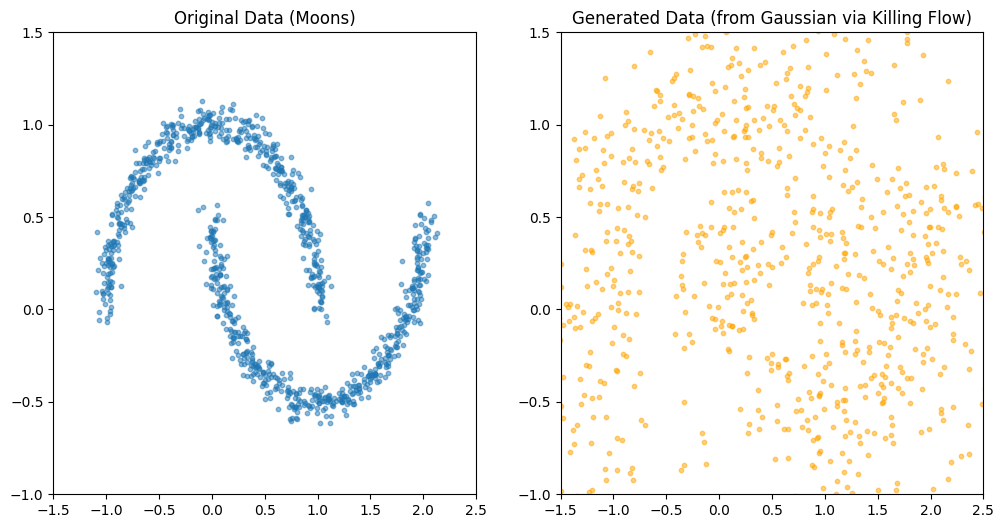

In [13]:
# --- 6. 可視化 (学習結果の確認) ---
print("Training finished. Visualizing...")

# 基本分布 z0 からサンプル
z0_samples = z0_dist.sample((data_points,))

# 逆方向 (0 -> T): 基本分布 z0 からデータ x へ
t_span_inv = torch.tensor([0.0, 1.0]).to(device)
x_generated = odeint(flow, z0_samples, t_span_inv, method='dopri5')[-1]

# プロット
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title("Original Data (Moons)")
ax1.scatter(x_data.detach().numpy()[:, 0], x_data.detach().numpy()[:, 1], s=10, alpha=0.5)
ax1.set_xlim(-1.5, 2.5)
ax1.set_ylim(-1, 1.5)

ax2.set_title("Generated Data (from Gaussian via Killing Flow)")
ax2.scatter(x_generated.detach().numpy()[:, 0], x_generated.detach().numpy()[:, 1], s=10, alpha=0.5, c='orange')
ax2.set_xlim(-1.5, 2.5)
ax2.set_ylim(-1, 1.5)

plt.show()

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
# odeint_adjoint はメモリ効率が良いですが、
# まずは動作原理が分かりやすい通常の odeint を使います
from torchdiffeq import odeint 

# --- 0. 準備 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. 標準的な CNF のための ODE 関数 ---
# (v_theta と trace(div(v_theta)) の両方を計算する)
class ODEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        # ネットワーク v_theta(z, t)
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    # v_theta(z, t) を計算
    def get_v(self, t, z):
        t_vec = torch.ones(z.shape[0], 1).to(z) * t
        tz = torch.cat([z, t_vec], dim=1)
        return self.net(tz)

    # trace(div(v_theta)) を計算
    def get_trace(self, t, z):
        # z は勾配計算のために requires_grad=True が必要
        z_copy = z.detach().clone().requires_grad_(True)
        v = self.get_v(t, z_copy)
        
        trace = 0.0
        # 2D なので、ヤコビアンの対角成分を直接計算
        for i in range(self.input_dim):
            # v[:, i] の z_copy に対する勾配を計算
            grad_v_i = torch.autograd.grad(
                v[:, i].sum(), z_copy, create_graph=True
            )[0]
            # 対角成分 (dv_i / dz_i) のみを取り出す
            trace += grad_v_i[:, i]
            
        return trace.contiguous().view(-1, 1) # (batch_size, 1)

    def forward(self, t, state):
        # state は (z, logp_diff) のタプル
        z, _ = state
        
        # --- 1. dz/dt = v_theta(z, t) ---
        dz_dt = self.get_v(t, z)
        
        # --- 2. d(logp)/dt = -trace(div(v_theta)) ---
        dlogp_dt = -self.get_trace(t, z)
        
        # 両方の時間発展を返す
        return (dz_dt, dlogp_dt)

# --- 2. トイデータ生成 (Moons) ---
data_points = 1000
x_data, _ = make_moons(n_samples=data_points, noise=0.05)
x_data = torch.tensor(x_data).float().to(device)

# --- 3. 基本分布 (z0) ---
z0_dist = torch.distributions.MultivariateNormal(
    torch.zeros(2).to(device),
    torch.eye(2).to(device)
)

# --- 4. モデルのインスタンス化 ---
flow = ODEFunc(input_dim=2, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

# --- 5. 学習ループ ---
num_epochs = 200
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # 積分時間: T=1.0 から 0.0 へ
    t_span = torch.tensor([1.0, 0.0]).to(device)
    
    # 初期状態:
    # z(T) = x_data
    # logp(T) = 0 (積分の初期値)
    initial_state = (x_data, torch.zeros(x_data.shape[0], 1).to(device))
    
    # ODEを解く
    # solution_t は (z(t), logp_diff(t)) のリスト
    solution_t = odeint(
        flow, initial_state, t_span, method='dopri5'
    )
    
    # T=0 時点 (積分終了時) の値を取得
    z0_pred = solution_t[0][-1]      # z(0)
    logp_diff = solution_t[1][-1]    # logp(0) - logp(T) = integral_T^0(-trace)

    # --- 6. 損失関数 ---
    # log p(x) = log p(z0) - integral_0^T(trace)
    #
    # d(logp)/dt = -trace
    # integral_T^0(d(logp)/dt) = integral_T^0(-trace)
    # logp(0) - logp(T) = integral_T^0(-trace)
    #
    # `logp_diff` は `logp(0)` (初期値 0 で積分) なので:
    # `logp_diff` = logp(0) - logp(T) = integral_T^0(-trace)
    #
    # log p(x) = log p(z0) + (logp(T) - logp(0))
    # log p(x) = log p(z0) - (logp(0) - logp(T))
    # log p(x) = log p(z0) + logp_diff
    
    log_prob_z0 = z0_dist.log_prob(z0_pred)
    log_prob_x = log_prob_z0 + logp_diff.squeeze() # (B, 1) -> (B)
    
    # 対数尤度 log p(x) を最大化 = 負の対数尤度を最小化
    loss = -log_prob_x.mean()
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# --- 7. 可視化 (学習結果の確認) ---
print("Training finished. Visualizing...")

# 基本分布 z0 からサンプル
z0_samples = z0_dist.sample((data_points,))

# 逆方向 (0 -> T): 基本分布 z0 からデータ x へ
# 積分時間: 0.0 から 1.0 へ
t_span_inv = torch.tensor([0.0, 1.0]).to(device)


Epoch 10, Loss: 1.4280
Epoch 20, Loss: 0.0356
Epoch 30, Loss: -1.5403
Epoch 40, Loss: -3.5992
Epoch 50, Loss: -6.4006
Epoch 60, Loss: -10.1865
Epoch 70, Loss: -15.1959
Epoch 80, Loss: -21.6719
Epoch 90, Loss: -29.8627
Epoch 100, Loss: -40.0188
Epoch 110, Loss: -52.3857
Epoch 120, Loss: -67.1970
Epoch 130, Loss: -84.6718
Epoch 140, Loss: -105.0105
Epoch 150, Loss: -128.3946
Epoch 160, Loss: -154.9940
Epoch 170, Loss: -184.9704
Epoch 180, Loss: -218.4783
Epoch 190, Loss: -255.6737
Epoch 200, Loss: -296.7307
Training finished. Visualizing...


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

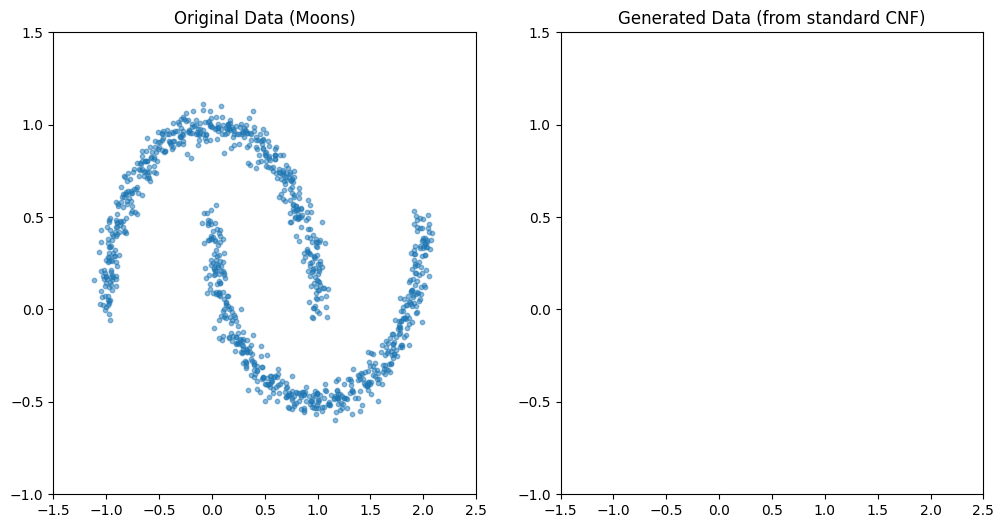

In [17]:

# 初期状態: z(0) = z0_samples, logp(0) = 0
initial_state_inv = (z0_samples, torch.zeros(z0_samples.shape[0], 1).to(device))

# ODEを解く
# (可視化だけなので、勾配計算は不要)
solution_inv_t = odeint(
    flow, initial_state_inv, t_span_inv, method='dopri5'
)
# T=1.0 時点 (積分終了時) の z(T) = x_generated を取得
x_generated = solution_inv_t[0][-1]


# プロット
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title("Original Data (Moons)")
ax1.scatter(x_data.detach().numpy()[:, 0], x_data.detach().numpy()[:, 1], s=10, alpha=0.5)
ax1.set_xlim(-1.5, 2.5)
ax1.set_ylim(-1, 1.5)

ax2.set_title("Generated Data (from standard CNF)")
ax2.scatter(x_generated.detach().numpy()[:, 0], x_generated.detach().numpy()[:, 1], s=10, alpha=0.5, c='orange')
ax2.set_xlim(-1.5, 2.5)
ax2.set_ylim(-1, 1.5)

plt.show()